<a href="https://colab.research.google.com/github/densmyslov/ais-data-pipeline/blob/dev/notebooks/data_ingestion_with__profiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The goal of this notebook is

# Raw Data Ingestion - Single File

* go to [https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2024/index.html](https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2024/index.html),
* right click on any of the zip files, and
* copy its link address,
* for example: https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_02.zip

let's try if we can use the  url to download the files:

In [18]:
import requests

url = 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_02.zip'
response = requests.get(url, stream=True)
print(response.status_code)

200


since we got status code 200, we can keep going with our approach. Let's download a file.  

Since we are going to use AWS lambdas to download the files, we won't use requests module - it is not part of the standard AWS Linux 2 and would require a docker image or a layer.  

The simplest way is to use http.client - http is a default module included into AWS Linux 2.  

Let's download a sample file and do memory profiling:

In [1]:
pip install -q memory_profiler

In [20]:
import subprocess
import os
import glob

# Step 1: Write the download script
with open("download_http.py", "w") as f:
    f.write('''import http.client
import time

HOST     = "coast.noaa.gov"
PATH     = "/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_02.zip"
FILENAME = "AIS_2024_01_02.zip"
CHUNK    = 8192

start_time = time.time()

conn = http.client.HTTPSConnection(HOST)
conn.request("GET", PATH)
resp = conn.getresponse()

with open(FILENAME, "wb") as f:
    while True:
        chunk = resp.read(CHUNK)
        if not chunk:
            break
        f.write(chunk)

conn.close()

end_time = time.time()
download_time = end_time - start_time
print(f"Download time: {download_time:.2f} seconds")
''')

# Step 2: Run mprof profiling
subprocess.run(["mprof", "run", "--include-children", "python3", "download_http.py"], check=True)

# Step 3: Generate PNG from profiling data
subprocess.run(["mprof", "plot", "-o", "lean_http.png", "--title", "Memory/Time Profiling for Single File Download (http.client)"], check=True)

# Step 4: Parse download_time from download_http.py output (run again to capture stdout)
download_time = None
try:
    result = subprocess.run(["python3", "download_http.py"], capture_output=True, text=True, check=True)
    for line in result.stdout.splitlines():
        if "Download time:" in line:
            download_time = float(line.split(":")[1].strip().split()[0])
            break
except subprocess.CalledProcessError as e:
    print("Failed to run download script:", e)

# Step 5: Read max memory usage from latest mprofile_*.dat
def get_max_memory_from_mprof(filename_pattern):
    files = glob.glob(filename_pattern)
    if not files:
        print(f"No file matching pattern: {filename_pattern}")
        return None
    latest_file = max(files, key=os.path.getctime)
    print(f"Reading file: {latest_file}")
    max_mem = 0
    try:
        with open(latest_file, 'r') as f:
            for line in f:
                if line.startswith("MEM"):
                    parts = line.split()
                    memory = float(parts[1])
                    max_mem = max(max_mem, memory)
    except Exception as e:
        print(f"Error reading file {latest_file}: {e}")
        return None
    return max_mem

max_mem = get_max_memory_from_mprof("mprofile_*.dat")

# Step 6: Report results
if download_time is not None:
    print(f"✅ Download time: {download_time:.2f} seconds")
if max_mem is not None:
    print(f"📈 Max memory used: {max_mem:.2f} MiB")


Reading file: mprofile_20250721022457.dat
✅ Download time: 3.03 seconds
📈 Max memory used: 20.04 MiB


### Memory and Time Profiling: Single File Download with `http.client`

This chart shows the memory and time profile for downloading a single file using Python’s built-in `http.client` module.

- **Black Line**: Represents the memory usage of the main Python process and its child processes over time. This is possible because the script was run with the `--include-children` flag using `mprof run`.

- **Red Line** : Indicates the memory usage attributed specifically to child processes, helping isolate their memory footprint from the main process.

- **Scope**: The memory profile reflects only the memory used by the download script itself. It does **not** represent the total system memory usage.

- **Colab Context**: Google Colab notebooks typically consume **over 1 GB** of system memory even when idle, due to the overhead from the notebook interface, kernel, and browser environment.

- **Download Time Note**: The reported download time depends primarily on the **speed of the remote server** (in this case, NOAA) and the **network connection** between the server and the Colab VM. It may vary significantly based on external bandwidth and server load.



To check the **total virtual machine (VM) memory usage** in Colab, click the **downward arrow** next to **"RAM / Disk"** in the top-right corner of the notebook interface. Then select **"View resources"** to see real-time metrics for RAM, disk usage, and active sessions.


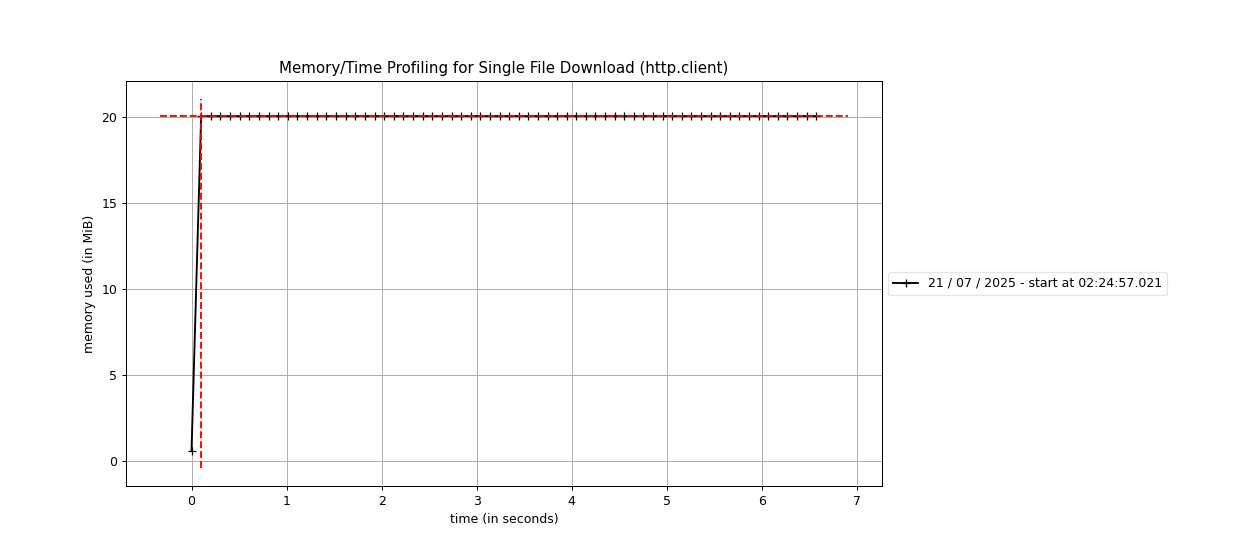

In [21]:
from IPython.display import Image
Image('lean_http.png')

### Main Factors That Determine Download Time

- **Server throughput and load**: How fast NOAA’s servers can read from disk, process and stream the ZIP file. Under heavy load, response times can spike.

- **Network path characteristics**: Bandwidth, latency, and packet loss between the Colab VM (which itself may be in a particular Google datacenter region) and the NOAA server. Internet congestion, routing changes, and peering can all introduce variability.

- **Protocol overhead**: DNS resolution time, TCP handshake (and window-size negotiation), TLS handshake if HTTPS, and any HTTP redirects—all add a small but sometimes measurable delay.

- **Client-side factors**: CPU time spent in Python’s I/O loop and writing to disk (especially if you’re also profiling memory), the buffer (chunk) size you choose, and any garbage-collection pauses can slightly affect the wall-clock time.

- **Repetition and caching effects**: Subsequent downloads may hit caches (in Cloudflare, DNS resolvers, or the server itself) and be faster; first-run TLS certificates might also be cached.


# Raw Data ingestion - Multiple Files

In [ ]:
!pip install -q aiohttp memory_profiler

In [ ]:
%%bash

# 2) Save this as download_http_async.py
cat > download_http_async.py << 'EOF'
import asyncio
import aiohttp
import os

# === configure these ===
HOST   = "coast.noaa.gov"
PATHS  = [
    "/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_02.zip",
    "/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_03.zip",
    "/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_04.zip",
    # …add as many as you like…
]
CHUNK_SIZE   = 1024 * 8
CONCURRENCY  = 5      # max simultaneous downloads
OUTPUT_DIR   = "downloads"
# ======================

os.makedirs(OUTPUT_DIR, exist_ok=True)

async def download_one(session: aiohttp.ClientSession, path: str, sem: asyncio.Semaphore):
    filename = os.path.join(OUTPUT_DIR, os.path.basename(path))
    url = f"https://{HOST}{path}"
    async with sem:
        async with session.get(url) as resp:
            resp.raise_for_status()
            with open(filename, "wb") as f:
                async for chunk in resp.content.iter_chunked(CHUNK_SIZE):
                    f.write(chunk)
    print(f"✔ downloaded {filename}")

async def main():
    sem = asyncio.Semaphore(CONCURRENCY)
    timeout = aiohttp.ClientTimeout(total=None)  # or tune per-request timeouts
    async with aiohttp.ClientSession(timeout=timeout) as session:
        tasks = [download_one(session, p, sem) for p in PATHS]
        # gather will run them all, but only CONCURRENCY at once
        await asyncio.gather(*tasks)

if __name__ == "__main__":
    asyncio.run(main())
EOF

# 3) Profile memory usage exactly as before
mprof run --include-children python3 download_http_async.py

# 4) Plot
mprof plot -o lean_async_http.png


✔ downloaded downloads/AIS_2024_01_02.zip
✔ downloaded downloads/AIS_2024_01_04.zip
✔ downloaded downloads/AIS_2024_01_03.zip
mprof: Sampling memory every 0.1s
running new process
Using last profile data.


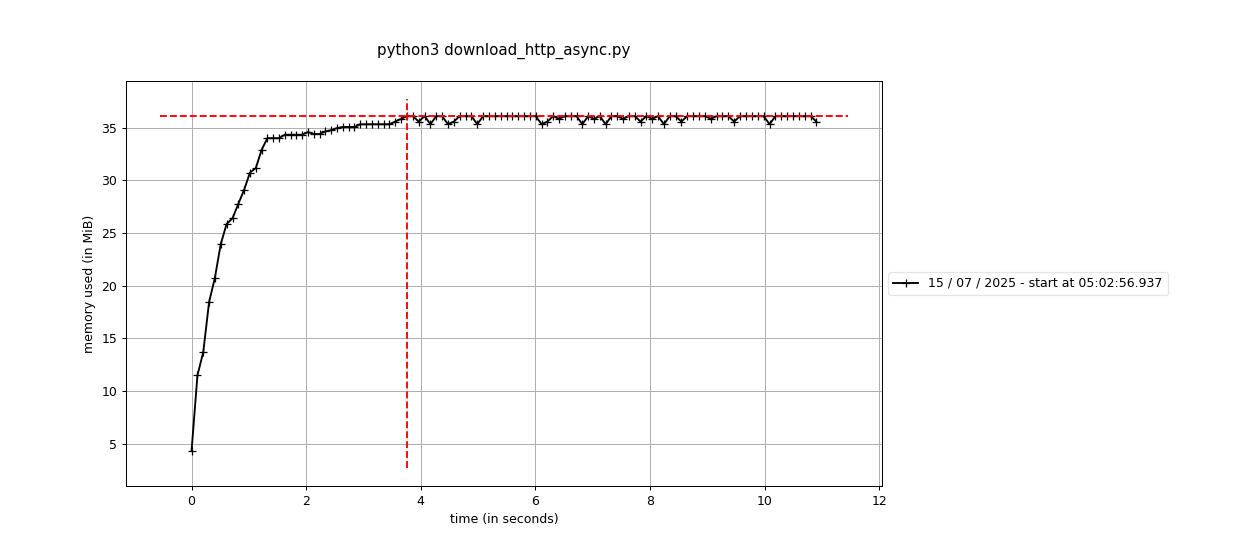

In [ ]:
from IPython.display import Image, display

# load by filename
img = Image(filename="lean_async_http.png")
display(img)

the memory profiling chart above shows that memory consumption peaked at ~ 36 Mb. It means that with 2 additional files we consumed (36 - 21)  15 Mb of memory, or 7.5 Mb per each additional file.  

This makes it possible to add even more files.

In [ ]:
HOST         = "coast.noaa.gov"
START_DATE   = datetime(2024, 1, 2)
NUM_DAYS     = 20
YEAR         = START_DATE.year
CHUNK_SIZE   = 1024 * 8
CONCURRENCY  = 5
OUTPUT_DIR   = "downloads"

PATHS = [
    f"/htdata/CMSP/AISDataHandler/{YEAR}/AIS_{(START_DATE + timedelta(days=i)).strftime('%Y_%m_%d')}.zip"
    for i in range(NUM_DAYS)
]

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
PATHS

['/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_02.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_03.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_04.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_05.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_06.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_07.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_08.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_09.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_10.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_11.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_12.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_13.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_14.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_15.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_16.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_17.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_18.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_1

In [ ]:
%%bash
# 1) Install aiohttp and memory_profiler
# pip install -q aiohttp memory_profiler

# 2) Write the async downloader as a script
cat > download_http_async.py << 'EOF'
import asyncio
import aiohttp
import os
from datetime import datetime, timedelta

# === configure these ===
HOST        = "coast.noaa.gov"
START_DATE  = datetime(2024, 1, 2)
NUM_DAYS    = 10
YEAR        = START_DATE.year
CHUNK_SIZE  = 1024 * 8
CONCURRENCY = 5
OUTPUT_DIR  = "downloads"

# generate N days of AIS files
PATHS = [
    f"/htdata/CMSP/AISDataHandler/{YEAR}/AIS_{(START_DATE + timedelta(days=i)).strftime('%Y_%m_%d')}.zip"
    for i in range(NUM_DAYS)
]
# ======================

os.makedirs(OUTPUT_DIR, exist_ok=True)

async def download_one(session, path, sem):
    filename = os.path.join(OUTPUT_DIR, os.path.basename(path))
    url = f"https://{HOST}{path}"
    async with sem:
        async with session.get(url) as resp:
            resp.raise_for_status()
            with open(filename, "wb") as f:
                async for chunk in resp.content.iter_chunked(CHUNK_SIZE):
                    f.write(chunk)
    print(f"✔ downloaded {filename}")

async def main():
    sem = asyncio.Semaphore(CONCURRENCY)
    timeout = aiohttp.ClientTimeout(total=None)
    async with aiohttp.ClientSession(timeout=timeout) as session:
        tasks = [download_one(session, p, sem) for p in PATHS]
        await asyncio.gather(*tasks)

if __name__ == "__main__":
    asyncio.run(main())
EOF

# 3) Profile memory usage
mprof run --include-children python3 download_http_async.py

# 4) Generate the plot
mprof plot -o lean_async_10_http.png


✔ downloaded downloads/AIS_2024_01_04.zip
✔ downloaded downloads/AIS_2024_01_03.zip
✔ downloaded downloads/AIS_2024_01_02.zip
✔ downloaded downloads/AIS_2024_01_06.zip
✔ downloaded downloads/AIS_2024_01_05.zip
✔ downloaded downloads/AIS_2024_01_09.zip
✔ downloaded downloads/AIS_2024_01_11.zip
✔ downloaded downloads/AIS_2024_01_07.zip
✔ downloaded downloads/AIS_2024_01_08.zip
✔ downloaded downloads/AIS_2024_01_10.zip
mprof: Sampling memory every 0.1s
running new process
Using last profile data.


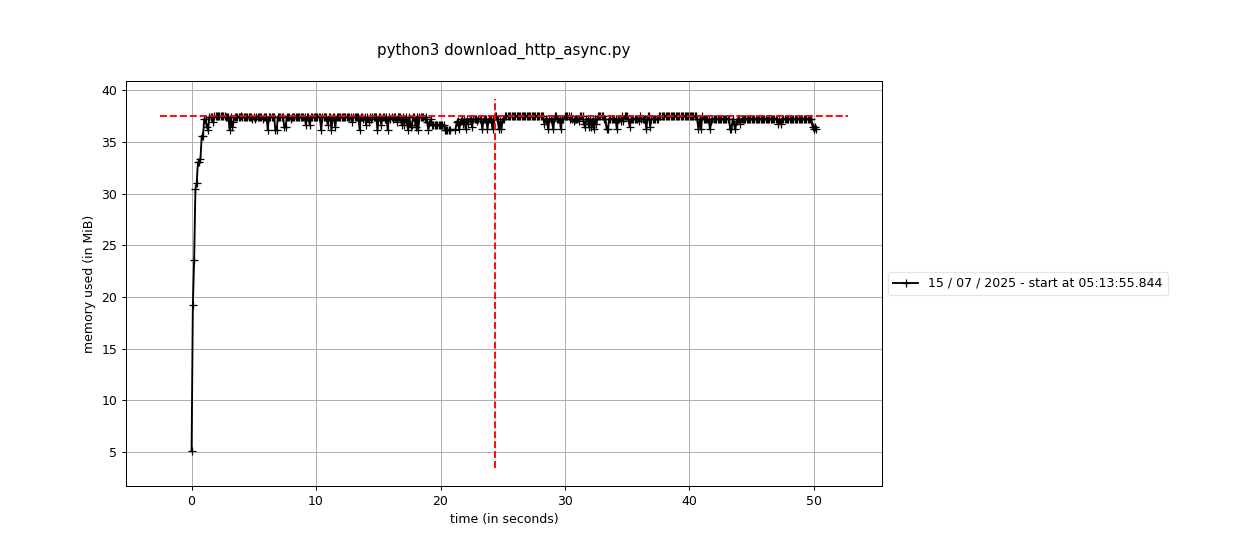

In [ ]:
img = Image(filename="lean_async_10_http.png")
display(img)

In [ ]:
%%bash
# 1) Install aiohttp and memory_profiler
# pip install -q aiohttp memory_profiler

# 2) Write the async downloader as a script
cat > download_http_async.py << 'EOF'
import asyncio
import aiohttp
import os
from datetime import datetime, timedelta

# === configure these ===
HOST        = "coast.noaa.gov"
START_DATE  = datetime(2024, 1, 1)
NUM_DAYS    = 20
YEAR        = START_DATE.year
CHUNK_SIZE  = 1024 * 8
CONCURRENCY = 5
OUTPUT_DIR  = "downloads"

# generate N days of AIS files
PATHS = [
    f"/htdata/CMSP/AISDataHandler/{YEAR}/AIS_{(START_DATE + timedelta(days=i)).strftime('%Y_%m_%d')}.zip"
    for i in range(NUM_DAYS)
]
# ======================

os.makedirs(OUTPUT_DIR, exist_ok=True)

async def download_one(session, path, sem):
    filename = os.path.join(OUTPUT_DIR, os.path.basename(path))
    url = f"https://{HOST}{path}"
    async with sem:
        async with session.get(url) as resp:
            resp.raise_for_status()
            with open(filename, "wb") as f:
                async for chunk in resp.content.iter_chunked(CHUNK_SIZE):
                    f.write(chunk)
    print(f"✔ downloaded {filename}")

async def main():
    sem = asyncio.Semaphore(CONCURRENCY)
    timeout = aiohttp.ClientTimeout(total=None)
    async with aiohttp.ClientSession(timeout=timeout) as session:
        tasks = [download_one(session, p, sem) for p in PATHS]
        await asyncio.gather(*tasks)

if __name__ == "__main__":
    asyncio.run(main())
EOF

# 3) Profile memory usage
mprof run --include-children python3 download_http_async.py

# 4) Generate the plot
mprof plot -o lean_async_20_http.png


✔ downloaded downloads/AIS_2024_01_04.zip
✔ downloaded downloads/AIS_2024_01_01.zip
✔ downloaded downloads/AIS_2024_01_02.zip
✔ downloaded downloads/AIS_2024_01_03.zip
✔ downloaded downloads/AIS_2024_01_05.zip
✔ downloaded downloads/AIS_2024_01_09.zip
✔ downloaded downloads/AIS_2024_01_06.zip
✔ downloaded downloads/AIS_2024_01_10.zip
✔ downloaded downloads/AIS_2024_01_08.zip
✔ downloaded downloads/AIS_2024_01_07.zip
✔ downloaded downloads/AIS_2024_01_14.zip
✔ downloaded downloads/AIS_2024_01_11.zip
✔ downloaded downloads/AIS_2024_01_12.zip
✔ downloaded downloads/AIS_2024_01_15.zip
✔ downloaded downloads/AIS_2024_01_13.zip
✔ downloaded downloads/AIS_2024_01_16.zip
✔ downloaded downloads/AIS_2024_01_17.zip
✔ downloaded downloads/AIS_2024_01_18.zip
✔ downloaded downloads/AIS_2024_01_19.zip
✔ downloaded downloads/AIS_2024_01_20.zip
mprof: Sampling memory every 0.1s
running new process
Using last profile data.


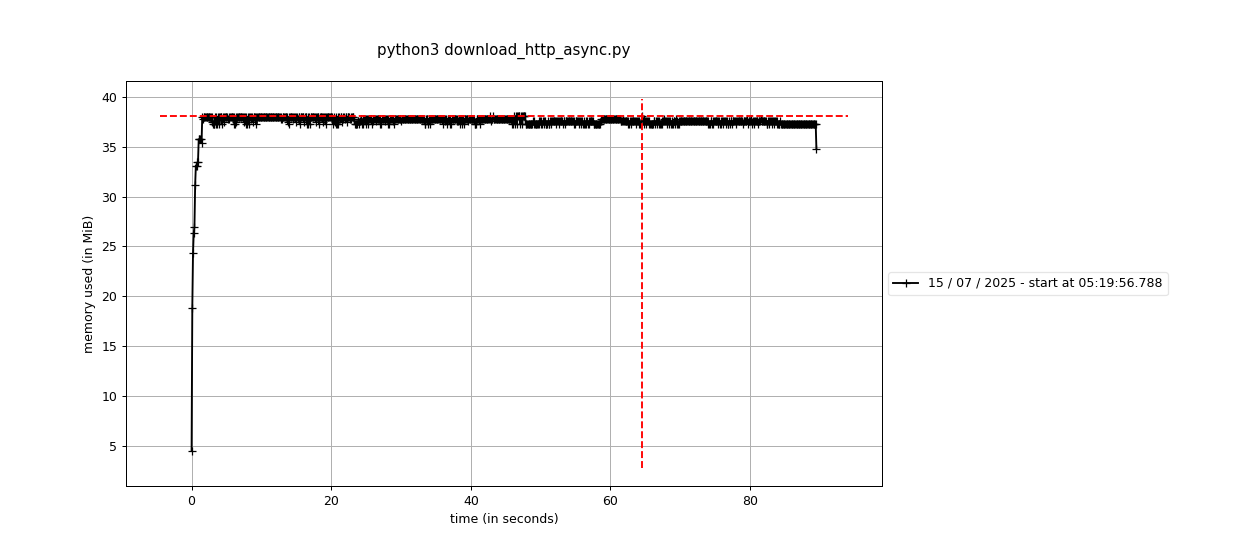

In [ ]:
img = Image(filename="lean_async_20_http.png")
display(img)

# parallel with wget

In [ ]:
%%bash

# Write Python code into download_http_async.py
cat > download_http_async.py << 'EOF'
import asyncio
import os
from datetime import datetime, timedelta

# === config ===
START_DATE   = datetime(2024, 1, 2)
NUM_DAYS     = 10
CONCURRENCY  = 5
HOST         = "https://coast.noaa.gov"
BASE_PATH    = "/htdata/CMSP/AISDataHandler/2024"
OUTPUT_DIR   = "downloads"
# ==============

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Generate the list of URLs
URLS = [
    f"{HOST}{BASE_PATH}/AIS_{(START_DATE + timedelta(days=i)).strftime('%Y_%m_%d')}.zip"
    for i in range(NUM_DAYS)
]

async def download_with_wget(url: str, sem: asyncio.Semaphore):
    filename = os.path.join(OUTPUT_DIR, os.path.basename(url))
    async with sem:
        process = await asyncio.create_subprocess_exec(
            'wget', url,
            '-O', filename,
            '--quiet',
            '--show-progress',
            '--no-verbose'
        )
        await process.communicate()
        print(f"✔ downloaded {filename}")

async def main():
    sem = asyncio.Semaphore(CONCURRENCY)
    tasks = [download_with_wget(url, sem) for url in URLS]
    await asyncio.gather(*tasks)

if __name__ == "__main__":
    asyncio.run(main())
EOF

# Now run the profiler
mprof run --include-children python3 download_http_async.py
mprof plot -o wget_async_plot.png


✔ downloaded downloads/AIS_2024_01_04.zip
✔ downloaded downloads/AIS_2024_01_03.zip
✔ downloaded downloads/AIS_2024_01_02.zip
✔ downloaded downloads/AIS_2024_01_06.zip
✔ downloaded downloads/AIS_2024_01_05.zip
✔ downloaded downloads/AIS_2024_01_11.zip
✔ downloaded downloads/AIS_2024_01_09.zip
✔ downloaded downloads/AIS_2024_01_10.zip
✔ downloaded downloads/AIS_2024_01_08.zip
✔ downloaded downloads/AIS_2024_01_07.zip
mprof: Sampling memory every 0.1s
running new process
Using last profile data.


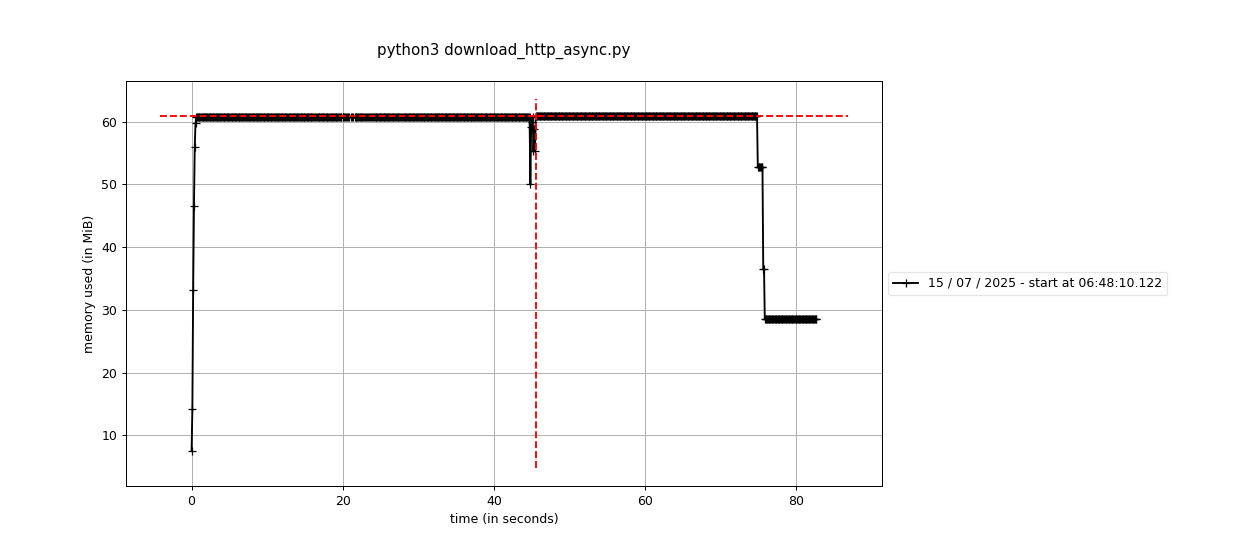

In [ ]:
img = Image(filename="wget_async_plot.png")
display(img)

Add your comment about the chart here.

This chart shows the memory and time profile for downloading a single file using `http.client`. The black line indicates the total memory usage, which is relatively stable throughout the download, stabilizing at approximately 21 MiB. The red line shows the memory usage of the child process (the Python script itself). The x-axis represents time, and the y-axis represents memory usage in MiB. The download time for this file was 7.40 seconds. The maximum memory utilized was {max_mem:.2f} MiB. The profile shows that this method is memory-efficient for downloading a single file.